<a href="https://colab.research.google.com/github/kaisarfardin6620/Quora-Question-Pair-Classification-Using-Sbert-And-Deep-Learning./blob/main/Quora_Question_Pair_Classification_Using_Sbert_And_Deep_Learning_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nltk==3.8.1 spacy==3.6.0

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Embedding
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Lambda
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.system('echo 3 | sudo tee /proc/sys/m/drop_caches')


256

In [4]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
train_df = pd.read_csv('/content/drive/MyDrive/Dataset/abcd/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Dataset/abcd/test.csv')

In [7]:
train_subset, _ = train_test_split(train_df, test_size=0.9, random_state=42)
test_subset, _ = train_test_split(test_df, test_size=0.9, random_state=42)

In [8]:
train_subset.shape

(40429, 6)

In [9]:
test_subset.shape

(234579, 3)

In [10]:
train_subset.describe()

,id,qid1,qid2,is_duplicate
count,40429.000000,40429.000000,40429.000000,40429.000000
mean,201738.315887,216954.520419,220765.498207,0.371763
std,116714.090457,157528.219730,159488.380214,0.483282
min,5.000000,3.000000,12.000000,0.000000
25%,101046.000000,74545.000000,75121.000000,0.000000
50%,201671.000000,191529.000000,197421.000000,0.000000
75%,302118.000000,345931.000000,353517.000000,1.000000
max,404284.000000,537926.000000,537927.000000,1.000000


In [11]:
test_subset.describe()

,test_id
count,2.345790e+05
mean,1.173493e+06
std,6.770211e+05
min,8.000000e+00
25%,5.887095e+05
50%,1.173274e+06
75%,1.760875e+06
max,2.345783e+06


In [12]:
print("Train Dataset Info:")
print(train_subset.info())
print("\nTest Dataset Info:")
print(test_subset.info())

Train Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 40429 entries, 204673 to 121958
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            40429 non-null  int64 
 1   qid1          40429 non-null  int64 
 2   qid2          40429 non-null  int64 
 3   question1     40429 non-null  object
 4   question2     40429 non-null  object
 5   is_duplicate  40429 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 2.2+ MB
None

Test Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 234579 entries, 727224 to 2219110
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   test_id    234579 non-null  int64 
 1   question1  234579 non-null  object
 2   question2  234578 non-null  object
dtypes: int64(1), object(2)
memory usage: 7.2+ MB
None


In [13]:
print("\nMissing values in train data:\n", train_subset.isnull().sum())
print("\nMissing values in test data:\n", test_subset.isnull().sum())


Missing values in train data:
 id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

Missing values in test data:
 test_id      0
question1    0
question2    1
dtype: int64


In [14]:
train_subset.dropna(inplace=True)
test_subset.dropna(inplace=True)

<ipython-input-15-ecfe5741e07c>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train_subset["is_duplicate"], palette="coolwarm")


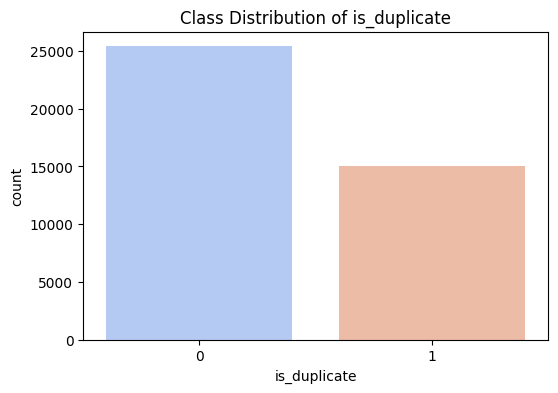

In [15]:
plt.figure(figsize=(6,4))
sns.countplot(x=train_subset["is_duplicate"], palette="coolwarm")
plt.title("Class Distribution of is_duplicate")
plt.show()

In [16]:
train_subset['question1'] = train_subset['question1'].fillna('')
train_subset['question2'] = train_subset['question2'].fillna('')

In [17]:
print("Class Distribution Before SMOTE:", Counter(train_subset["is_duplicate"]))

Class Distribution Before SMOTE: Counter({0: 25399, 1: 15030})


In [18]:
def preprocess_text(text):
    # Tokenization
    tokens = nltk.word_tokenize(text.lower())

    # Removing stopwords and punctuation
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and token.isalnum()]

    # Lemmatization (optional but recommended)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return ' '.join(tokens)

train_subset['question1'] = train_subset['question1'].apply(preprocess_text)
train_subset['question2'] = train_subset['question2'].apply(preprocess_text)

In [19]:
vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features
X_text = vectorizer.fit_transform(train_subset['question1'] + ' ' + train_subset['question2'])

In [20]:
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_smote, y_smote = smote.fit_resample(X_text, train_subset["is_duplicate"])

In [21]:
model = SentenceTransformer('all-mpnet-base-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
X_q1_embeddings = model.encode(train_subset['question1'].tolist())
X_q2_embeddings = model.encode(train_subset['question2'].tolist())

In [ ]:
X = np.hstack((X_q1_embeddings, X_q2_embeddings))
y = train_subset["is_duplicate"].values

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_text, train_subset["is_duplicate"], test_size=0.2, random_state=42, stratify=y)

In [ ]:
print("Train Size:", X_train.shape, "Validation Size:", X_val.shape)

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_val)
print("Logistic Regression Accuracy:", accuracy_score(y_val, lr_preds))

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_preds = dt.predict(X_val)
print("DecisionTree Accuracy:", accuracy_score(y_val, dt_preds))

In [ ]:
ann_model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

In [ ]:
ann_model.summary()

In [ ]:
ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
history = ann_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=64, callbacks=[early_stopping])

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Overfitting Check: Training vs Validation Loss")
plt.show()

In [ ]:
lstm_model = Sequential([
    Embedding(input_dim=5000, output_dim=300, input_length=X_train.shape[1]),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
lstm_model.build(input_shape=(None, X_train.shape[1]))

In [ ]:
lstm_model.summary()

In [ ]:
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=64, callbacks=[early_stopping])

In [ ]:
X_train_reshaped = X_train.toarray().reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_reshaped = X_val.toarray().reshape(X_val.shape[0], X_val.shape[1], 1)

In [ ]:
input_a = Input(shape=(X_train.shape[1], 1))
input_b = Input(shape=(X_train.shape[1], 1))

shared_dense = Dense(512, activation='relu')

encoded_a = shared_dense(input_a)
encoded_b = shared_dense(input_b)

In [ ]:
def euclidean_distance(vectors):
    x, y = vectors
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

distance = Lambda(euclidean_distance)([encoded_a, encoded_b])

In [ ]:
output = Dense(1, activation="sigmoid")(distance)

In [ ]:
siamese_model = tf.keras.Model(inputs=[input_a, input_b], outputs=output)
siamese_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
siamese_model.fit([X_train_reshaped, X_train_reshaped], y_train,
                  validation_data=([X_val_reshaped, X_val_reshaped], y_val),
                  epochs=10, batch_size=64, callbacks=[early_stopping])


In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Dataset/abcd/test.csv')

In [ ]:
final_predictions = ann_model.predict(X_val)

In [ ]:
final_predictions_binary = (final_predictions > 0.5).astype(int)

In [ ]:
submission_df = pd.DataFrame({
    "test_id": test_df["test_id"],
    "is_duplicate": final_predictions_binary
})

In [ ]:
submission_df.to_csv("final_submission.csv", index=False)
print("Submission file 'final_submission.csv' saved successfully!")

In [ ]:
print("Logistic Regression Classification Report:")
print(classification_report(y_val, lr_preds))

In [ ]:
print("\nSVM Classification Report:")
print(classification_report(y_val, dt_preds))

In [ ]:
ann_preds = (ann_model.predict(X_val) > 0.5).astype(int)
print("\nANN Classification Report:")
print(classification_report(y_val, ann_preds))

In [ ]:
lstm_preds = (lstm_model.predict(X_val) > 0.5).astype(int)
print("\nLSTM Classification Report:")
print(classification_report(y_val, lstm_preds))

In [ ]:
siamese_preds = (siamese_model.predict([X_val[:, :384], X_val[:, 384:]]) > 0.5).astype(int)
print("\nSiamese Network Classification Report:")
print(classification_report(y_val, siamese_preds))

In [ ]:
def plot_confusion_matrix(model_name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Duplicate", "Duplicate"], yticklabels=["Not Duplicate", "Duplicate"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

In [ ]:
plot_confusion_matrix("Logistic Regression", y_val, lr_preds)
plot_confusion_matrix("DecisionTree", y_val, dt_preds)
plot_confusion_matrix("ANN", y_val, ann_preds)
plot_confusion_matrix("LSTM", y_val, lstm_preds)
plot_confusion_matrix("Siamese Network", y_val, siamese_preds)

In [ ]:
plt.figure(figsize=(10, 6))
def plot_roc_curve(model_name, y_true, y_probs):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.2f})")

In [ ]:
plot_roc_curve("Logistic Regression", y_val, lr.predict_proba(X_val)[:,1])
plot_roc_curve("DecisionTree", y_val, dt.predict_proba(X_val)[:, 1])
plot_roc_curve("ANN", y_val, ann_model.predict(X_val))
plot_roc_curve("LSTM", y_val, lstm_model.predict(X_val))
plot_roc_curve("Siamese Network", y_val, siamese_model.predict([X_val[:, :384], X_val[:, 384:]]))

In [ ]:
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve for All Models")
plt.legend()
plt.show()

In [ ]:
cm_data = {
    "Logistic Regression": confusion_matrix(y_val, lr_preds).flatten(),
    "DecisionTree": confusion_matrix(y_val, dt_preds).flatten(),
    "ANN": confusion_matrix(y_val, ann_preds).flatten(),
    "LSTM": confusion_matrix(y_val, lstm_preds).flatten(),
    #"Siamese Network": confusion_matrix(y_val, siamese_preds).flatten()
}

In [ ]:
cm_df = pd.DataFrame(cm_data)

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(cm_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation of Confusion Matrices")
plt.show()